# Examining the effect of pooling operations on images

Read cifar 10 dataset and plot a sample image.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
img = x_train[1]
plt.figure(0, figsize=(4, 4))
plt.imshow(img)
print("Shape of image: {}".format(img.shape))

Shape of image: (32, 32, 3)


## Short presentation of image local entropy and shannon entropy.

Select two random images from the dataset. Then show the original image and plot the histogram. Also calculate the local entropy, plot the heatmap of the entropy values of the image and the relative histogram.

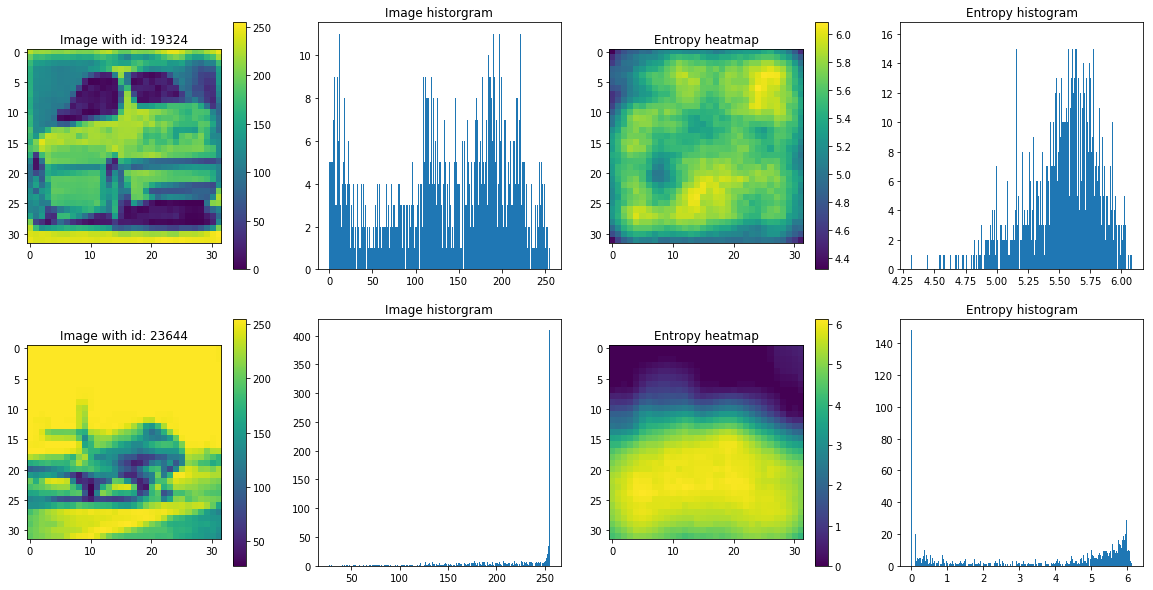

In [2]:
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
import random

idx1 = random.randint(0, len(x_train))
idx2 = random.randint(0, len(x_train)) 

img = x_train[idx1]
img = img[:,:,0]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
entr_img = entropy(img, disk(5))
current_img = axs[0, 0].imshow(img)
axs[0, 0].title.set_text("Image with id: {}".format(idx1))
fig.colorbar(current_img, ax=axs[0,0])

current_img = axs[0, 2].imshow(entr_img)
fig.colorbar(current_img, ax=axs[0,2])
axs[0, 2].title.set_text("Entropy heatmap")

axs[0, 1].hist(img.ravel(), bins=256)
axs[0, 1].title.set_text("Image historgram")
axs[0, 3].hist(entr_img.ravel(), bins=256)
axs[0, 3].title.set_text("Entropy histogram")

img = x_train[idx2]
img = img[:,:,0]

entr_img = entropy(img, disk(5))
current_img = axs[1, 0].imshow(img)
axs[1, 0].title.set_text("Image with id: {}".format(idx2))
fig.colorbar(current_img, ax=axs[1,0])

current_img = axs[1, 2].imshow(entr_img)
fig.colorbar(current_img, ax=axs[1,2])
axs[1, 2].title.set_text("Entropy heatmap")

axs[1, 1].hist(img.ravel(), bins=256)
axs[1, 1].title.set_text("Image historgram")
axs[1, 3].hist(entr_img.ravel(), bins=256)
axs[1, 3].title.set_text("Entropy histogram")

plt.show()

Calculate local entropy and shannon entropy of all images. Given a 32x32 image, local entropy is a 32x32 matrix and shannon entropy is a scalar.

In [3]:
from skimage.measure import shannon_entropy

def f(x):
    return entropy(x, disk(5))

def ff(x):
    return shannon_entropy(x)
    
imgs = x_train[:,:,:,0]
print("Shape of 5000 images: {}".format(imgs.shape))
entr_imgs = np.array(list(map(f, imgs)))
print("Shape of local entropy of 5000 images: {}".format(entr_imgs.shape))

shannon_entr_imgs = np.array(list(map(ff, imgs)))
print("Shannon entropy of 5000 images is a scalar".format(shannon_entr_imgs.shape))

Shape of 5000 images: (50000, 32, 32)
Shape of local entropy of 5000 images: (50000, 32, 32)
Shannon entropy of 5000 images is a scalar


Next the feature distribution of the whole dataset is presented. For comparison the feature distribution of both the local and Shannon entropy are plotted. 

Mean value of all images 125.306918046875 and std 62.993219278136884


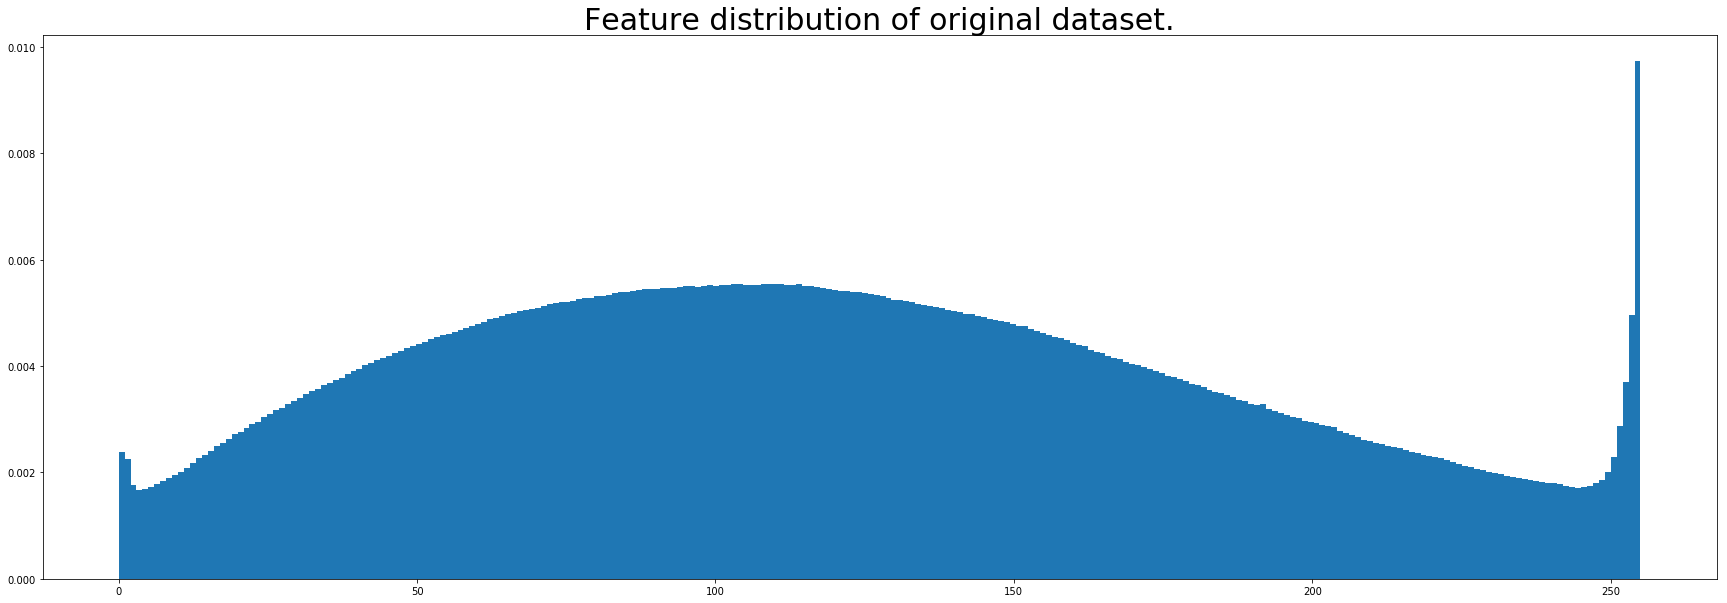

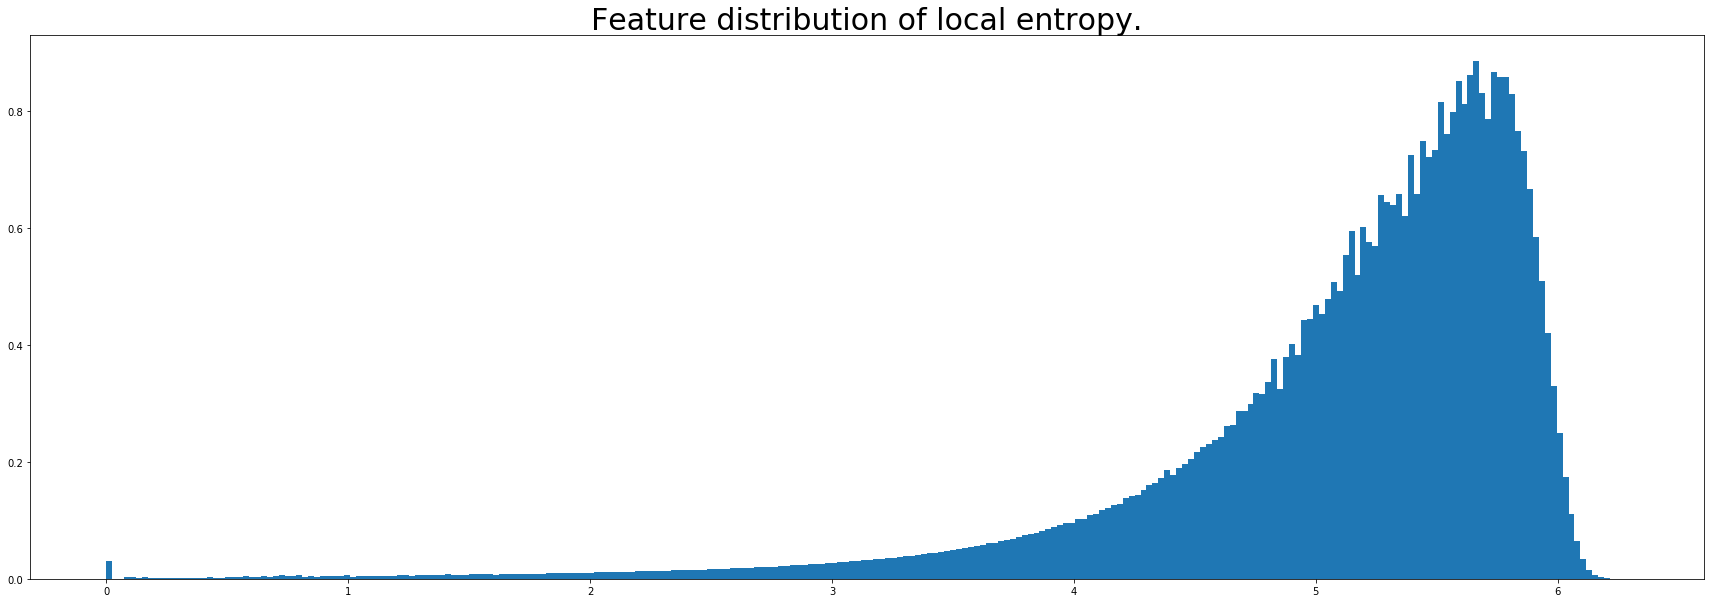

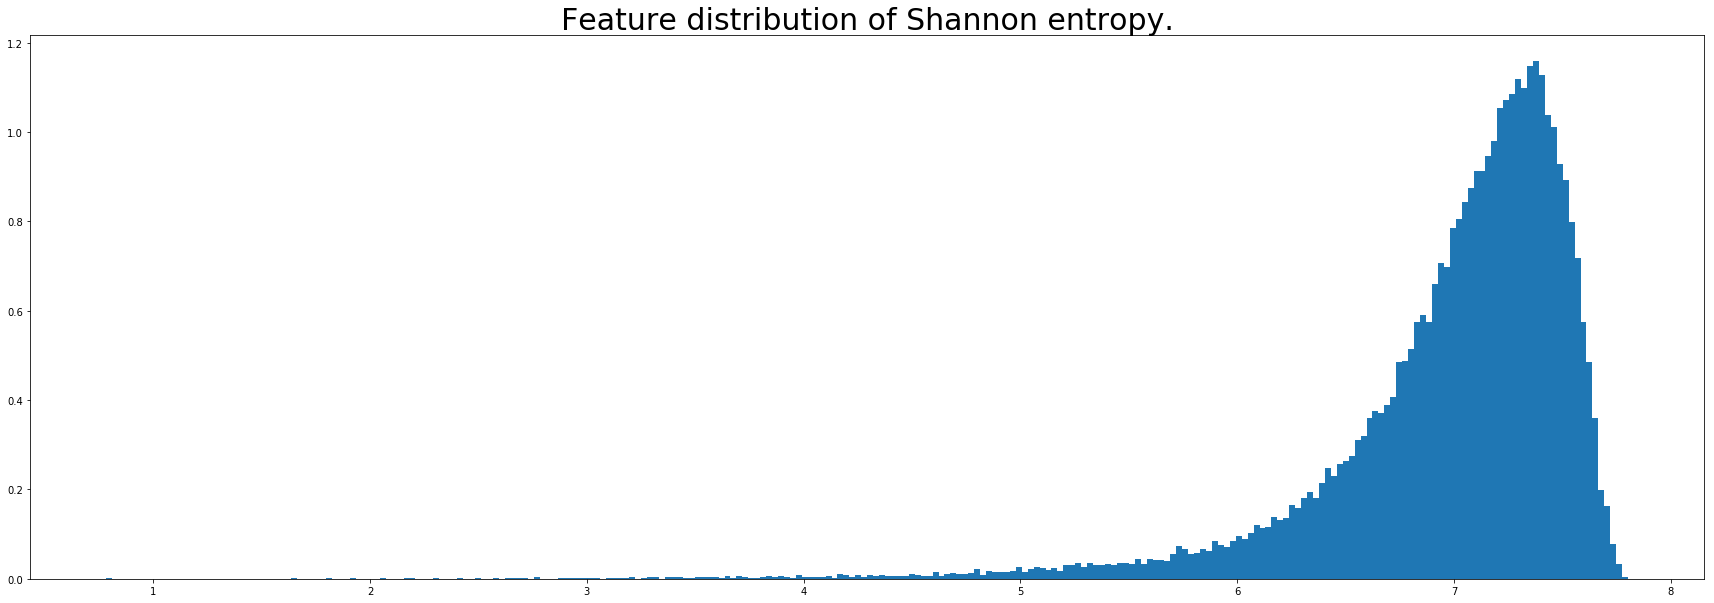

In [4]:
counter = 0
batch = 64
imax = int(len(imgs)/batch)
for i in range(0,imax):
    m = np.mean(imgs[batch*i:batch*i + batch])
    if m >= 125.3:
        counter += 1
print('Mean value of all images {} and std {}'.format(np.mean(imgs), np.std(imgs)))

plt.figure(1, figsize=(30, 10))
plt.hist(x_train.ravel(), bins=256, density=True)
plt.title("Feature distribution of original dataset.", fontsize=30)
plt.show()

plt.figure(2, figsize=(30, 10))
plt.hist(entr_imgs.ravel(), bins=256, density=True)
plt.title("Feature distribution of local entropy.", fontsize=30)
plt.show()

plt.figure(2, figsize=(30, 10))
plt.hist(shannon_entr_imgs.ravel(), bins=256, density=True)
plt.title("Feature distribution of Shannon entropy.", fontsize=30)
plt.show()

## Compare max, average and entropy pooling.


Implementation of max, min, average pooling operations and the variations of entropy pooling (high and low).

In [5]:
def flatten(X, window_h, window_w, window_c, out_h, out_w, stride=1, padding=0):
    X_padded = tf.pad(X, [[0, 0], [padding, padding], [padding, padding], [0, 0]])
    
    windows = []
    for y in range(out_h):
        for x in range(out_w):
            window = tf.slice(X_padded, [0, y * stride, x * stride, 0], [-1, window_h, window_w, -1])
            windows.append(window)
    stacked = tf.stack(windows)  # shape : [out_h, out_w, n, filter_h, filter_w, c]

    return tf.reshape(stacked, [-1, window_c * window_w * window_h])

def pool(X, pool_h=2, pool_w=2, padding=0, stride=2, mode='max'):
    n = 1
    c = 1
    n, h, w, c = [d for d in X.shape]

    out_h = (h + 2 * padding - pool_h) // stride + 1
    out_w = (w + 2 * padding - pool_w) // stride + 1

    X_flat = flatten(X, pool_h, pool_w, c, out_h, out_w, stride, padding)

    if mode is 'max':
        pool = tf.reduce_max(tf.reshape(X_flat, [out_h, out_w, n, pool_h * pool_w, c]), axis=3)
    elif mode is 'mean':
        pool = tf.reduce_mean(tf.reshape(X_flat, [out_h, out_w, n, pool_h * pool_w, c]), axis=3)
    elif mode is 'min':
        pool = tf.reduce_min(tf.reshape(X_flat, [out_h, out_w, n, pool_h * pool_w, c]), axis=3)
    else:
        pool = tf.reduce_max(tf.reshape(X_flat, [out_h, out_w, n, pool_h * pool_w, c]), axis=3)
    
    return tf.transpose(pool, [2, 0, 1, 3])


def entropy_pool(X, pool_h=2, pool_w=2, padding=0, stride=2, mode='high'):
    n, h, w, c = [d for d in X.shape]
    out_h = (h + 2 * padding - pool_h) // stride + 1
    out_w = (w + 2 * padding - pool_w) // stride + 1
    X_flat = flatten(X, pool_h, pool_w, c, out_h, out_w, stride, padding)

    nrows, ncols = [d.value for d in X_flat.get_shape()]
    size = nrows * ncols

    X_flat = tf.reshape(X_flat, [-1])
    y, idx, counts = tf.unique_with_counts(X_flat)

    elements_idx = tf.meshgrid(tf.range(0, size))
    indices_for_y = tf.gather(idx, elements_idx)

    x_counts = tf.cast(tf.gather(counts, indices_for_y), tf.float64)
    x_probs = tf.scalar_mul(float(1 / (size)), x_counts)
    x_entropies = tf.map_fn(lambda p: -p * tf.log(p), x_probs)
    x_entropies = tf.reshape(x_entropies, [out_h, out_w, n, pool_h * pool_w, c])
    
    X_flat = tf.reshape(X_flat, [out_h, out_w, n, pool_h * pool_w, c])

    if mode is 'high':
        max_entropy_indices = tf.argmin(x_entropies, axis=3, output_type=tf.int32)
    elif mode is 'low':
        max_entropy_indices = tf.argmax(x_entropies, axis=3, output_type=tf.int32)

    grid = tf.meshgrid(tf.range(0, x_entropies.shape[0]), tf.range(0, x_entropies.shape[1]),
                       tf.range(0, x_entropies.shape[2]), tf.range(0, x_entropies.shape[4]), indexing='ij')

    coords = tf.stack(grid + [max_entropy_indices], axis=-1)
    c = tf.unstack(coords, axis=-1)
    coords = tf.stack([c[0], c[1], c[2], c[4], c[3]], axis=-1)
    entropy_pool = tf.gather_nd(X_flat, coords)

    return tf.transpose(entropy_pool, [2, 0, 1, 3])


Demonstrating the effect of pooling operations, classic and entropy based ones, on random images from cifar dataset.
The pooling outputs are plotted for each case. Then their local and Shannon entropies are calculated and presented.
The feature distribution of the original image and of the output of pooling operations are also plotted, showing their statistical properties of mean and standard deviation. 

/home/christoforos/anaconda2/envs/tf-gpu/lib/python3.6/site-packages/skimage/util/dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/christoforos/anaconda2/envs/tf-gpu/lib/python3.6/site-packages/skimage/util/dtype.py:179: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


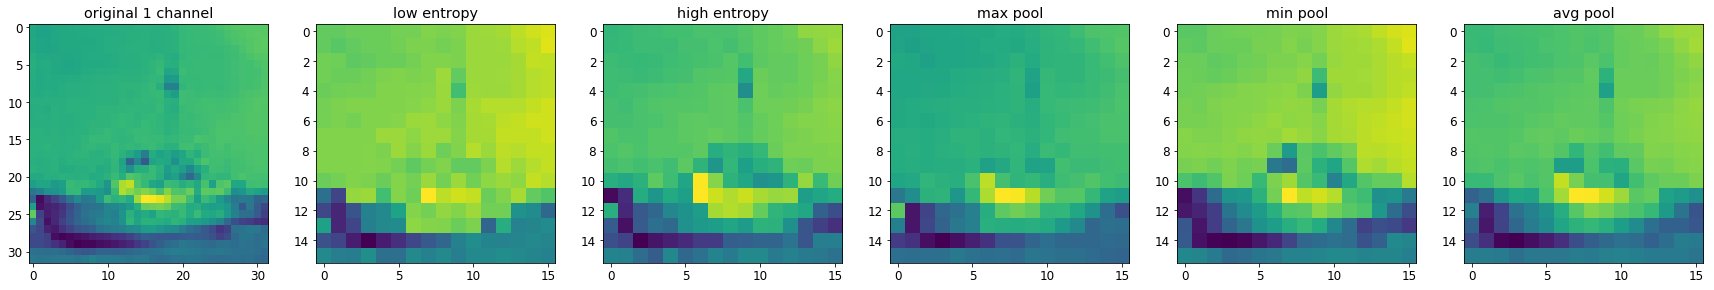

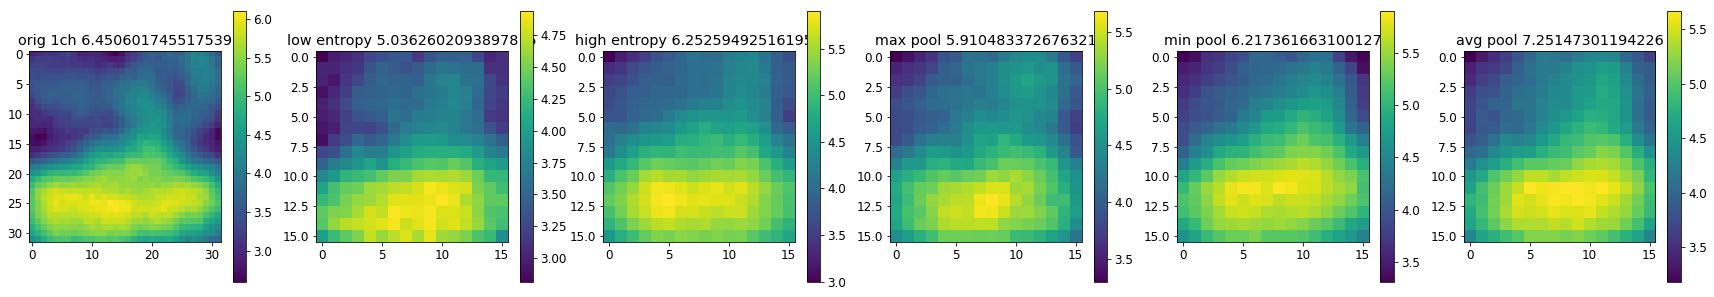

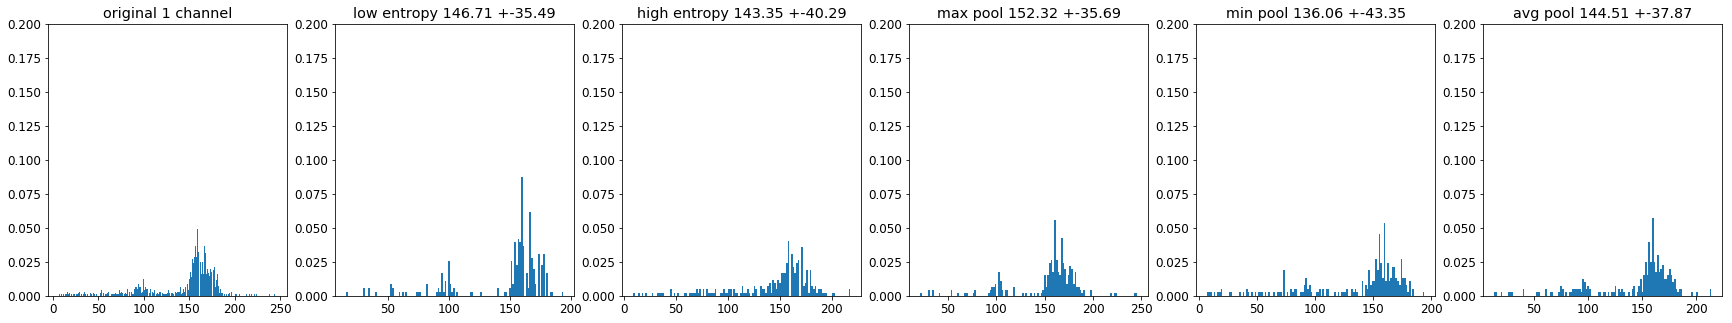

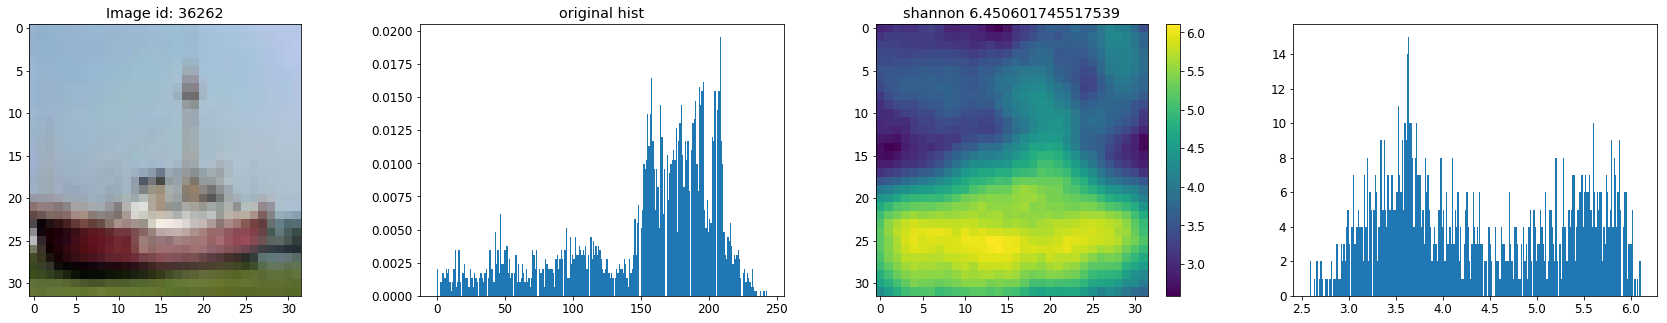

In [6]:
import matplotlib.pylab as pylab
import skimage
# print(pylab.rcParams.keys())
params = {
          'font.size': 12
#          'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#             'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)

sess = tf.InteractiveSession()

idx2 = random.randint(0, len(x_train)) 
img = x_train[idx2]
img = img[:,:,0]
img = tf.image.adjust_brightness(img, .01).eval()
size = 32
min_entropy = entropy_pool(np.reshape(img, (1, size, size, 1)), mode='low')
max_entropy = entropy_pool(np.reshape(img, (1, size, size, 1)), mode='high')

max_pool = pool(np.reshape(img, (1, size, size, 1)), mode='max')
mean_pool = tf.nn.avg_pool(tf.cast(np.reshape(img, (1, size, size, 1)), tf.float32), 
                               ksize=[1, 2, 2, 1], padding='SAME', strides=[1, 2, 2, 1])

min_pool = pool(np.reshape(img, (1, size, size, 1)), mode='min')

half_size = int(size/2)
max_entropy = tf.reshape(max_entropy, (half_size, half_size))
min_entropy = tf.reshape(min_entropy, (half_size, half_size))
max_pool = tf.reshape(max_pool, (half_size, half_size))
mean_pool = tf.reshape(mean_pool, (half_size, half_size))
min_pool = tf.reshape(min_pool, (half_size, half_size))
d = disk(5)

fig, axs = plt.subplots(1, 6, figsize=(30, 5))
axs[0].imshow(img)
axs[0].title.set_text('original 1 channel')
axs[1].imshow(min_entropy.eval())
axs[1].title.set_text('low entropy')
axs[2].imshow(max_entropy.eval())
axs[2].title.set_text('high entropy')
axs[3].imshow(max_pool.eval())
axs[3].title.set_text('max pool')
axs[4].imshow(min_pool.eval())
axs[4].title.set_text('min pool')
axs[5].imshow(mean_pool.eval())
axs[5].title.set_text('avg pool')

fig, axs = plt.subplots(1, 6, figsize=(30, 5))
current_img = axs[0].imshow(entropy(img, disk(5)))
fig.colorbar(current_img, ax=axs[0])
axs[0].title.set_text('orig 1ch {}'.format(shannon_entropy(img)))

current_img = axs[1].imshow(entropy(min_entropy.eval(), d))
fig.colorbar(current_img, ax=axs[1])
axs[1].title.set_text('low entropy {}'.format(shannon_entropy(min_entropy.eval())))

current_img = axs[2].imshow(entropy(max_entropy.eval(), d))
fig.colorbar(current_img, ax=axs[2])
axs[2].title.set_text('high entropy {}'.format(shannon_entropy(max_entropy.eval())))

current_img = axs[3].imshow(entropy(max_pool.eval(), d))
fig.colorbar(current_img, ax=axs[3])
axs[3].title.set_text('max pool {}'.format(shannon_entropy(max_pool.eval())))

current_img = axs[4].imshow(entropy(min_pool.eval(), d))
fig.colorbar(current_img, ax=axs[4])
axs[4].title.set_text('min pool {}'.format(shannon_entropy(min_pool.eval())))

current_img = axs[5].imshow(entropy(mean_pool.eval().astype(int), d))
fig.colorbar(current_img, ax=axs[5])
axs[5].title.set_text('avg pool {}'.format(shannon_entropy(mean_pool.eval())))

fig, axs = plt.subplots(1, 6, figsize=(30, 5))
for i in range(0, 6):
    axs[i].set_ylim([0,0.2])

axs[0].hist(img.ravel(), bins=256, density=True)
axs[0].title.set_text('original 1 channel')
axs[1].hist(min_entropy.eval().ravel(), bins=128, density=True)
axs[1].title.set_text('low entropy {} +-{}'.format(round(np.mean(min_entropy.eval()), 2), round(np.std(min_entropy.eval()), 2)))
axs[2].hist(max_entropy.eval().ravel(), bins=128, density=True)
axs[2].title.set_text('high entropy {} +-{}'.format(round(np.mean(max_entropy.eval()), 2), round(np.std(max_entropy.eval()), 2)))
axs[3].hist(max_pool.eval().ravel(), bins=128, density=True)
axs[3].title.set_text('max pool {} +-{}'.format(round(np.mean(max_pool.eval()), 2), round(np.std(max_pool.eval()), 2)))
axs[4].hist(min_pool.eval().ravel(), bins=128, density=True)
axs[4].title.set_text('min pool {} +-{}'.format(round(np.mean(min_pool.eval()), 2), round(np.std(min_pool.eval()), 2)))
axs[5].hist(mean_pool.eval().ravel(), bins=128, density=True)
axs[5].title.set_text('avg pool {:.2f} +-{:.2f}'.format(round(np.mean(mean_pool.eval()), 2), round(np.std(mean_pool.eval()), 2)))

fig, axs = plt.subplots(1, 4, figsize=(30, 5))
axs[0].imshow(x_train[idx2])
axs[0].title.set_text("Image id: {}".format(idx2))
axs[1].hist(x_train[idx2].ravel(), bins=256, density=True)
axs[1].title.set_text('original hist')
entr_1_ch = entropy(img, disk(5))
current_img = axs[2].imshow(entr_1_ch)
fig.colorbar(current_img, ax=axs[2])
shannon_entr = shannon_entropy(img)
axs[2].title.set_text('shannon {}'.format(shannon_entr))
axs[3].hist(entr_1_ch.ravel(), bins=256)
plt.show()


Showing the feature distribution of the original image and of the output of the following pooling operations: high entropy pool, max pool and average pool.
The following properties are also calculated for each case: cardinality of features, mean value, standard deviation and Shannon entropy.

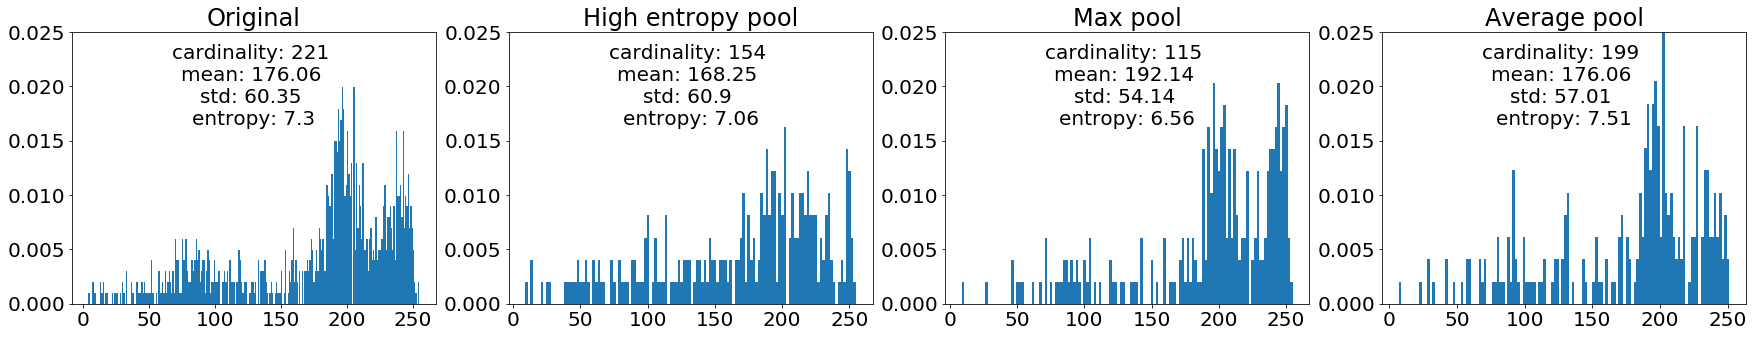

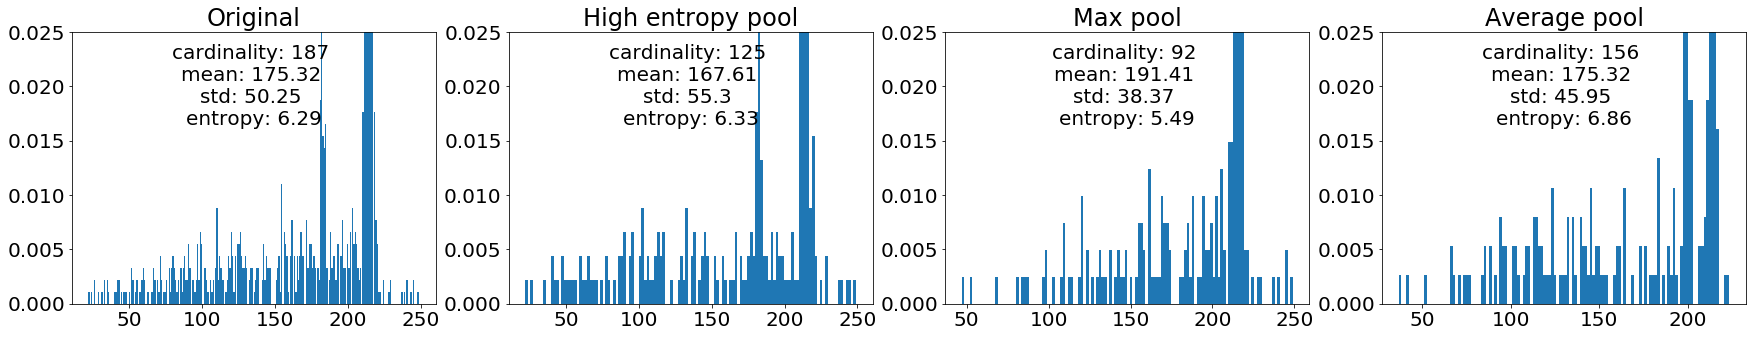

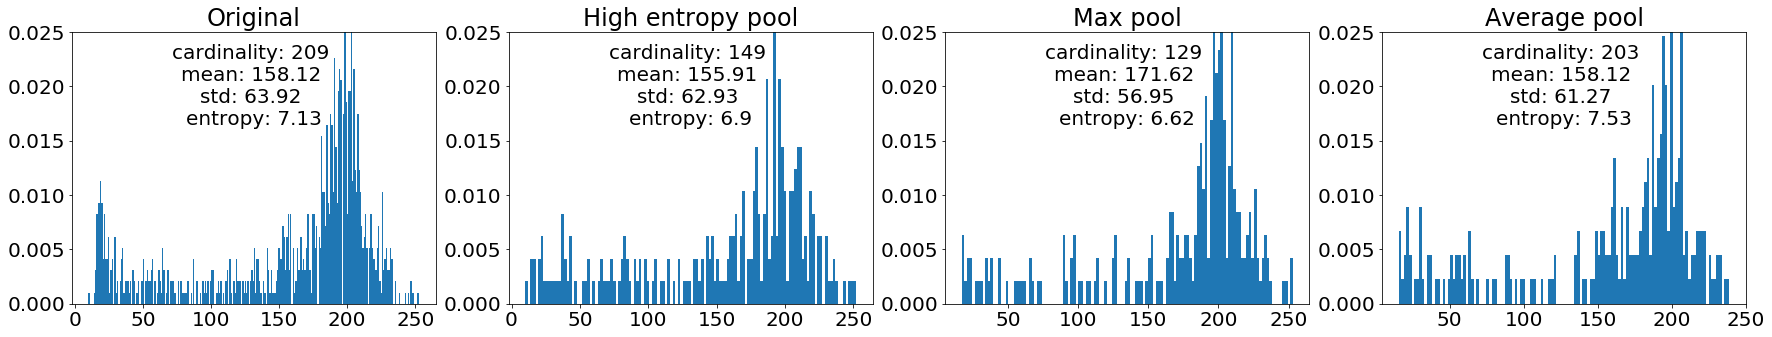

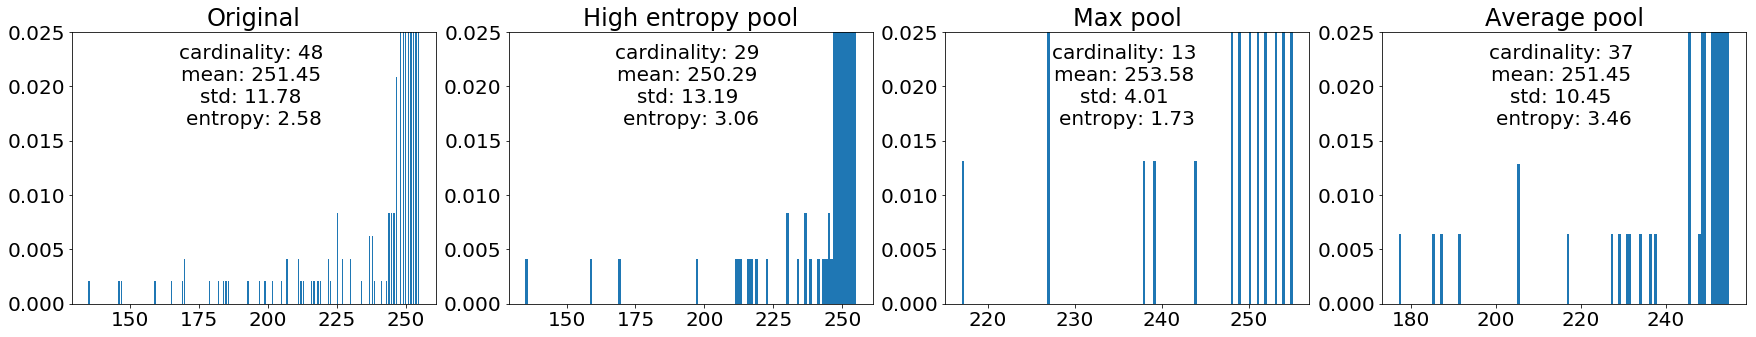

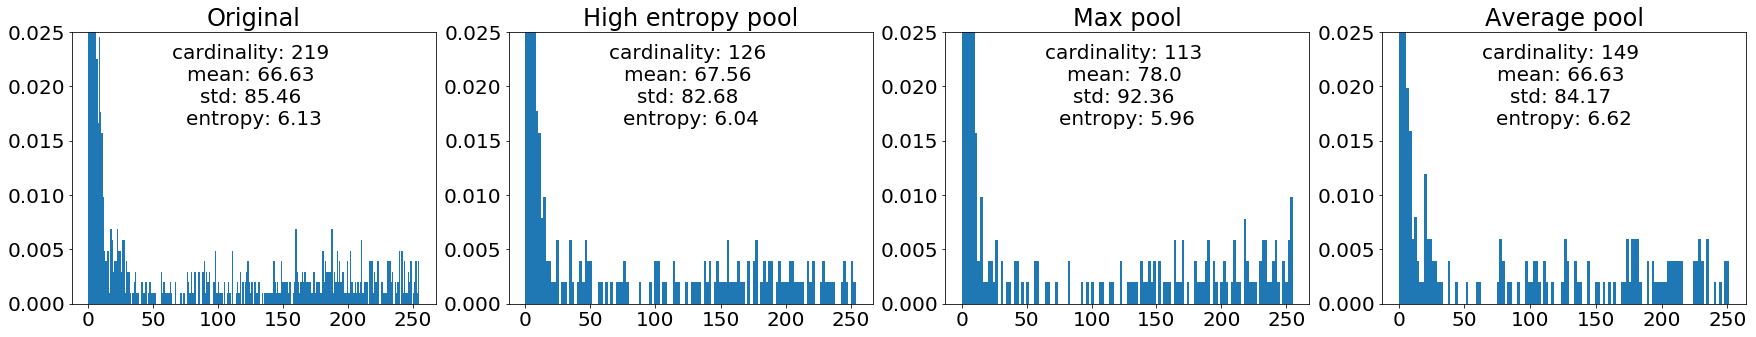

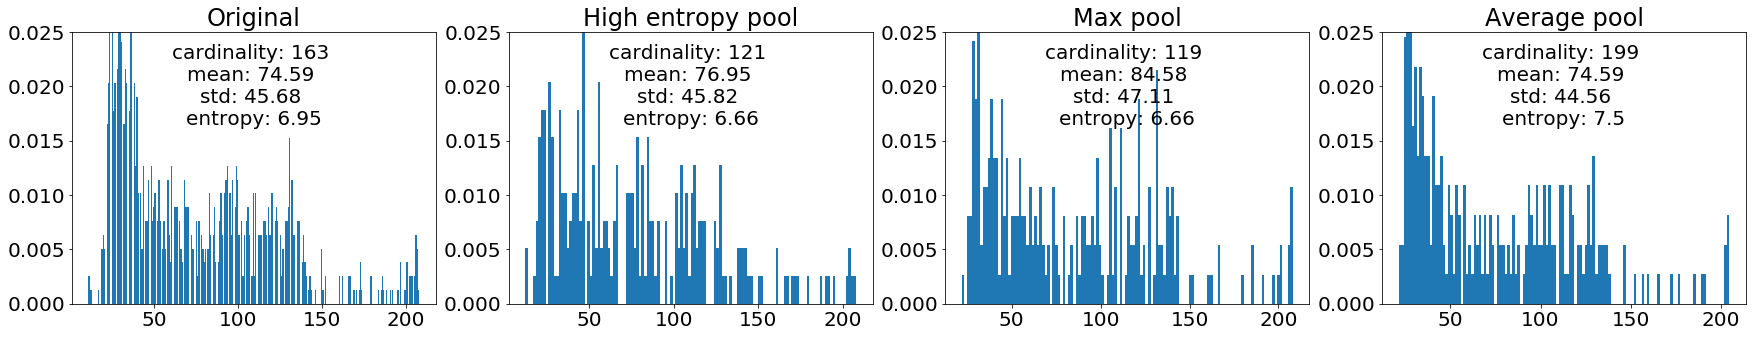

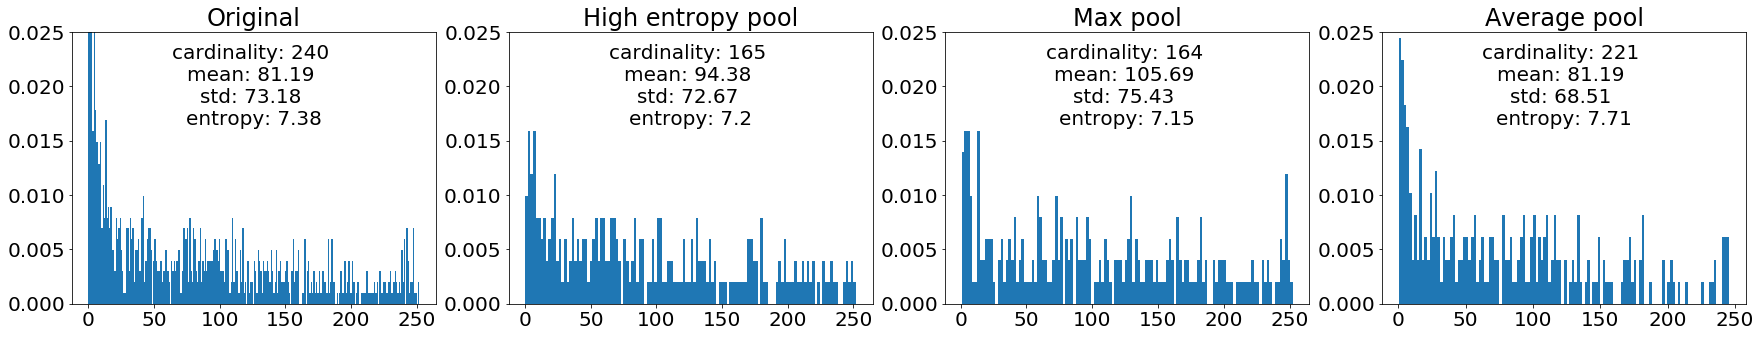

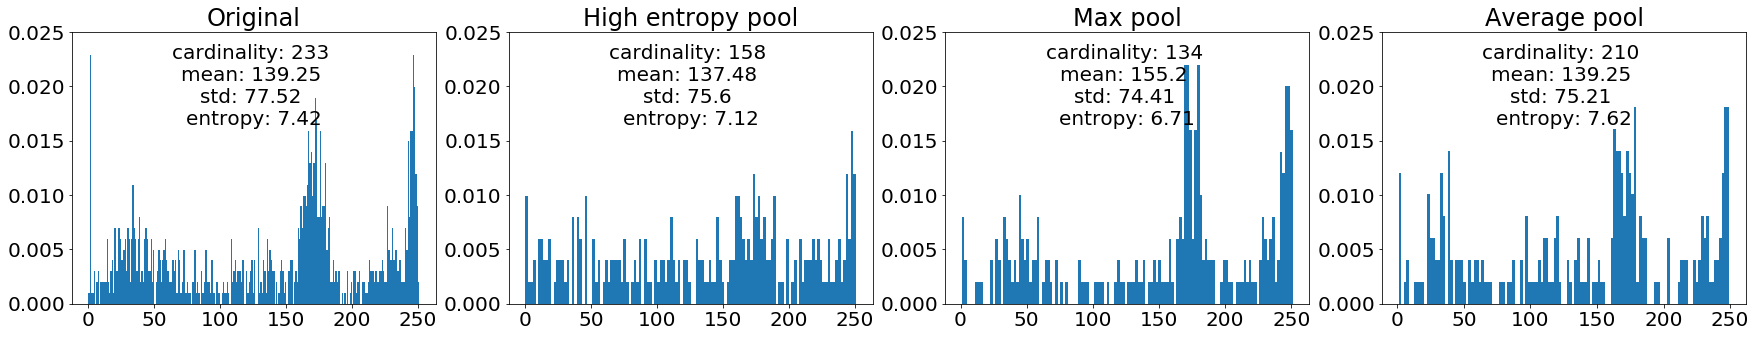

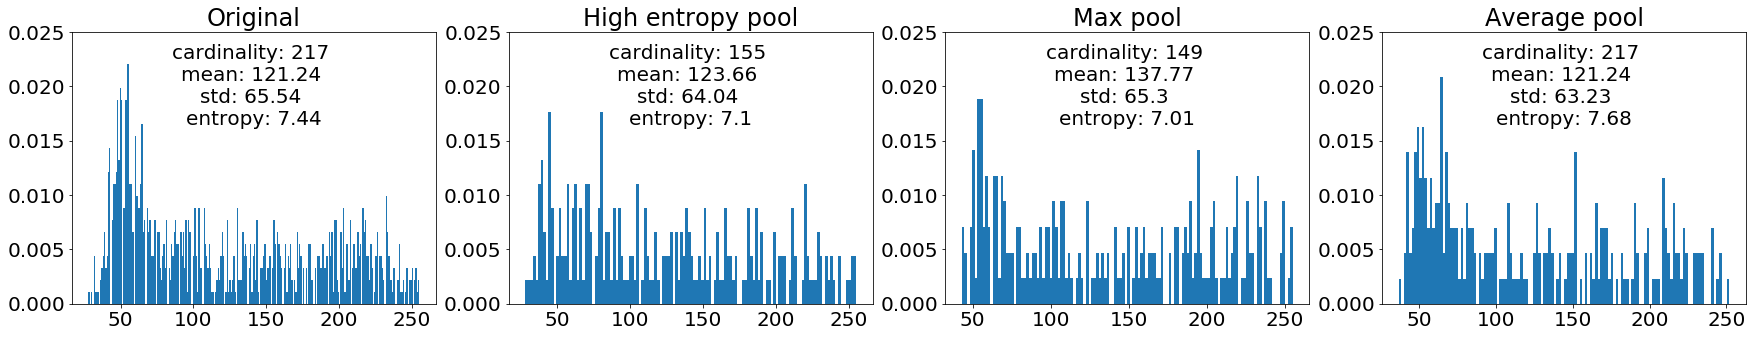

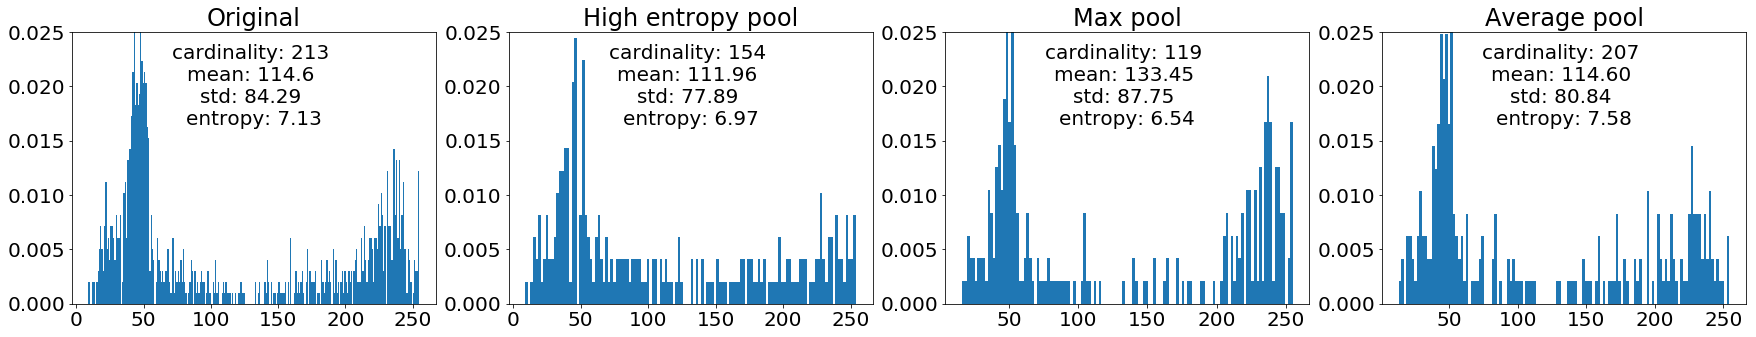

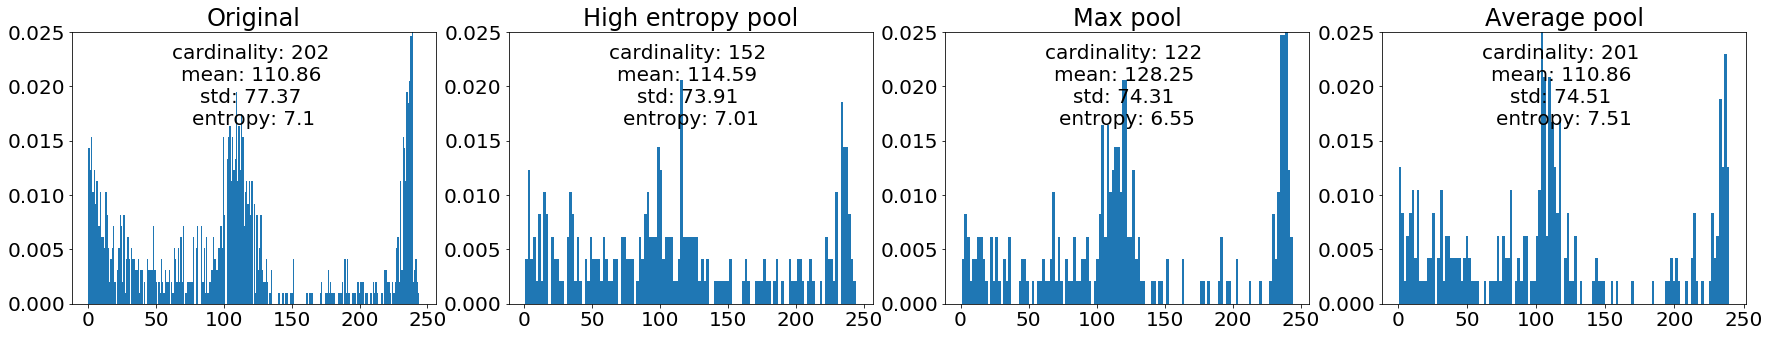

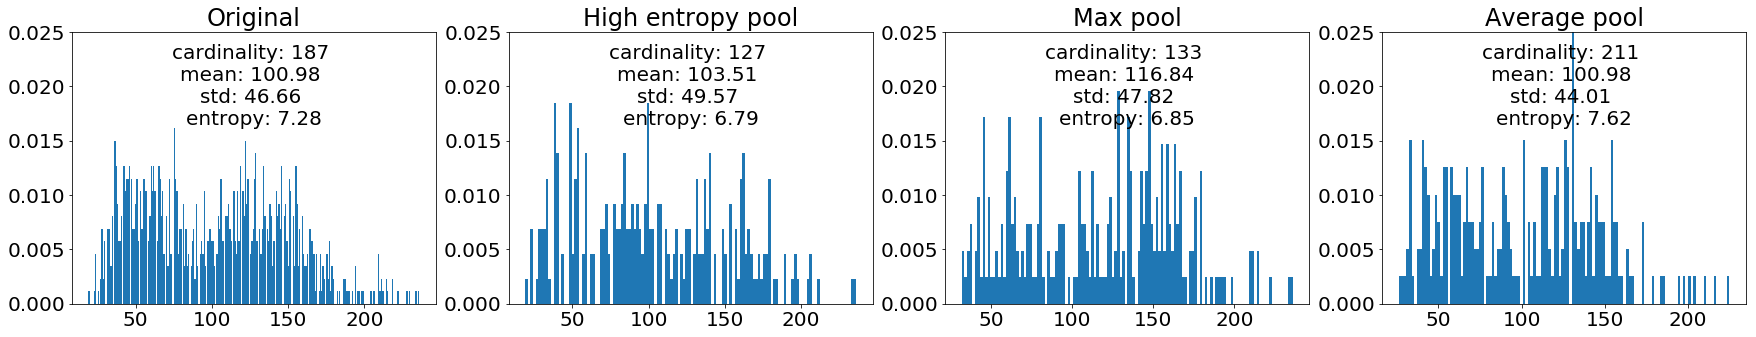

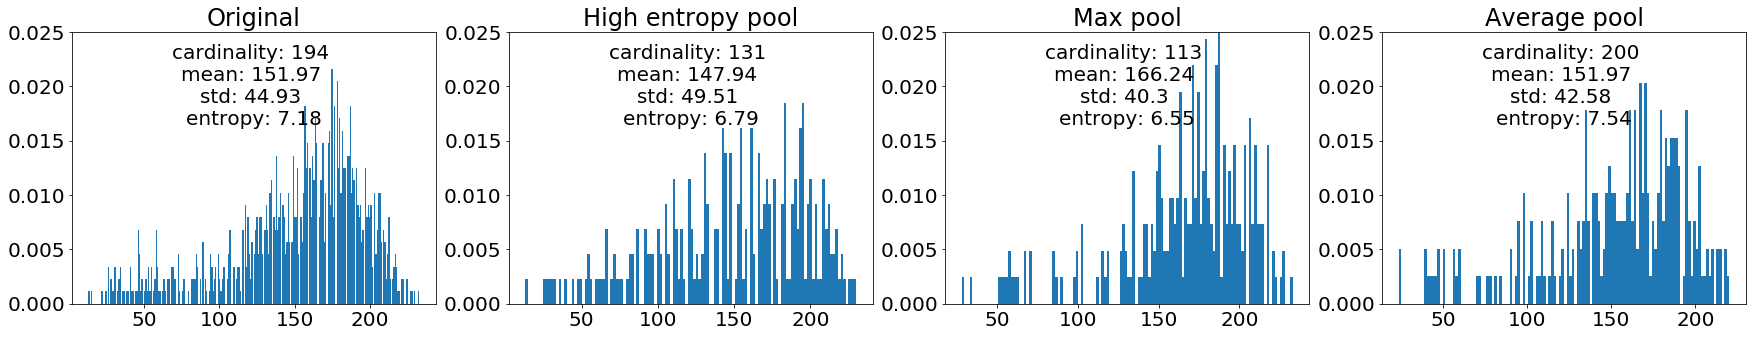

In [7]:
import matplotlib.pylab as pylab
# print(pylab.rcParams.keys())
params = {
          'font.size': 20
#          'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#             'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)
    
def show(idx, save_figure=False):
    img = x_train[idx]
    img = img[:, :, 0]
    size = 32
    min_entropy = entropy_pool(np.reshape(img, (1, size, size, 1)), mode='low')
    max_entropy = entropy_pool(np.reshape(img, (1, size, size, 1)), mode='high')

    max_pool = pool(np.reshape(img, (1, size, size, 1)), mode='max')
    mean_pool = pool(np.reshape(img, (1, size, size, 1)), mode='mean')
    min_pool = pool(np.reshape(img, (1, size, size, 1)), mode='min')
    mean_pool = tf.nn.avg_pool(tf.cast(np.reshape(img, (1, size, size, 1)), tf.float32), 
                               ksize=[1, 2, 2, 1], padding='SAME', strides=[1, 2, 2, 1])

    half_size = int(size / 2)
    max_entropy = tf.reshape(max_entropy, (half_size, half_size))
    min_entropy = tf.reshape(min_entropy, (half_size, half_size))
    max_pool = tf.reshape(max_pool, (half_size, half_size))
    mean_pool = tf.reshape(mean_pool, (half_size, half_size))
    min_pool = tf.reshape(min_pool, (half_size, half_size))

    num_of_plots = 4
    fig, axs = plt.subplots(1, num_of_plots, figsize=(30, 5))
    for i in range(0, num_of_plots):
        axs[i].set_ylim([0, 0.025])

    
    counter = 0
    axs[counter].hist(img.ravel(), bins=256, density=True)
    axs[counter].title.set_text('Original')
    
    t = 'cardinality: {} \nmean: {} \nstd: {} \nentropy: {}'.format(len(np.unique(img)),
                                                                    round(np.mean(img), 2),
                                                                    round(np.std(img), 2),
                                                                    round(shannon_entropy(img), 2))        
    axs[counter].text(0.5, 0.8, t, ha='center', va='center', transform=axs[counter].transAxes)
    
#     counter = counter + 1
#     axs[counter].hist(min_entropy.eval().ravel(), bins=128, density=True)
#     axs[counter].title.set_text('Low entropy pool')
#     t = 'cardinality: {} \nmean: {} std: {} \nshannon entr {}'.format(len(np.unique(min_entropy.eval())),
#                                                       round(np.mean(min_entropy.eval()), 2),
#                                                       round(np.std(min_entropy.eval()), 2),
#                                                       round(shannon_entropy(min_entropy.eval()), 2))
#     axs[counter].text(0.5, 0.8, t, ha='center', va='center', transform=axs[counter].transAxes)

    counter = counter + 1
    axs[counter].hist(max_entropy.eval().ravel(), bins=128, density=True)
    axs[counter].title.set_text('High entropy pool')
    t = 'cardinality: {} \nmean: {} \nstd: {} \nentropy: {}'.format(len(np.unique(max_entropy.eval())), 
                                                    round(np.mean(max_entropy.eval()), 2),
                                                    round(np.std(max_entropy.eval()), 2),
                                                    round(shannon_entropy(max_entropy.eval()), 2))        
    axs[counter].text(0.5, 0.8, t, ha='center', va='center', transform=axs[counter].transAxes)

    counter = counter + 1
    axs[counter].hist(max_pool.eval().ravel(), bins=128, density=True)
    axs[counter].title.set_text('Max pool') 
    t = 'cardinality: {} \nmean: {} \nstd: {} \nentropy: {}'.format(len(np.unique(max_pool.eval())), 
                                                    round(np.mean(max_pool.eval()), 2),
                                                    round(np.std(max_pool.eval()), 2),
                                                    round(shannon_entropy(max_pool.eval()), 2))
    axs[counter].text(0.5, 0.8, t, ha='center', va='center', transform=axs[counter].transAxes)

    # axs[4].hist(min_pool.eval().ravel(), bins=128, density=True)
    # axs[4].title.set_text('Min pool \nmean: {} std: {} \nshannon entr {}'.format(round(np.mean(min_pool.eval()), 2), 
    #                                                                              round(np.std(min_pool.eval()), 2),
    #                                                                              round(shannon_entropy(min_pool.eval()), 2)))
    counter = counter + 1
#     mean_pool = tf.cast(mean_pool, tf.int32)
    axs[counter].hist(mean_pool.eval().ravel(), bins=128, density=True)
    axs[counter].title.set_text('Average pool') 
    t = 'cardinality: {} \nmean: {:.2f} \nstd: {:.2f} \nentropy: {}'.format(len(np.unique(mean_pool.eval())), 
                                                    round(np.mean(mean_pool.eval()), 2),
                                                    round(np.std(mean_pool.eval()), 2),
                                                    round(shannon_entropy(mean_pool.eval()), 2))
    axs[counter].text(0.5, 0.8, t, ha='center', va='center', transform=axs[counter].transAxes)
    if save_figure:
        plt.savefig('pooling_distributions_{}'.format(idx))
    plt.show()

bright = [1167, 29522, 37414, 9881]

dark = [18988, 5256, 37891]

ra = [25260, 34117, 26109, 21784, 44543]

normal = [38165]

for b in bright:
    show(b)
    
for d in dark:
    show(d)

for r in ra:
    show(r)
    
for n in normal:
    show(n)